# Load_Important_Libraries 

In [1]:
import os
import cv2
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, InceptionResNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Activation,BatchNormalization

# Load_Data

In [2]:
# Define dataset paths
data_covid = r"D:\AMIT Course\Data Set\Image Classification - Covid-19 X-Ray\archive\COVID19"
data_normal = r"D:\AMIT Course\Data Set\Image Classification - Covid-19 X-Ray\archive\Normal"

# Initialize lists
filepaths = []
labels = []

# Function to read images from a directory
def load_images_from_folder(data_path, label_name):
    for file in os.listdir(data_path):
        filepaths.append(os.path.join(data_path, file))
        labels.append(label_name)

# Load COVID images
load_images_from_folder(data_covid, "COVID19")

# Load Normal images
load_images_from_folder(data_normal, "Normal")

# Create a combined DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

# Shuffle data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split_Data

In [3]:
# First, split into train+valid and test (80-20 split)
train_valid_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'], random_state=42)

# Then, split train+valid into train and validation (75-25 split)
train_df, valid_df = train_test_split(train_valid_df, test_size=0.25, stratify=train_valid_df['labels'], random_state=42)

# Final splits:
# Train: 60%, Validation: 20%, Test: 20%

# Dataset Sizes

In [4]:
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

Train size: 36
Validation size: 12
Test size: 12


# Data_Augmentation 

In [5]:
# Augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=0.45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    vertical_flip=True,
    #validation_split=0.2
)

def preprocess_image(image):
    return image.astype('float32') / 255. 
    
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
    #subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
    #subset='training'
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    class_mode='categorical'
    #subset='training'
)

Found 36 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.


# Add_Transfer_Learning

In [6]:
base_model = InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling="max",
    classes=1000,
    classifier_activation="softmax",
    name="inception_resnet_v2",)
base_model.trainable = False

In [7]:
# base_model = MobileNetV2(
#     include_top=False,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(224, 224, 3),
#     pooling="max",
#     classes=1000,
#     classifier_activation="softmax",
#     name="inception_resnet_v2",)
# base_model.trainable = False

In [8]:
# base_model = VGG16(
#      include_top=False,
#      weights="imagenet",
#      input_tensor=None,
#      input_shape=(224, 224, 3),
#      pooling=max,
#      classes=1000,
#      classifier_activation="softmax",
#      name="inception_resnet_v2",)

# base_model.trainable = False

# CNN

In [9]:
model = Sequential([
    base_model, 
    # Conv2D(64, (3, 3), activation='relu'),
    # MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
   # Dropout(0.2),
    Dense(2, activation='softmax')  
])

model.compile(optimizer=Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)
# Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 1536)           │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,298,306 (210.95 MB)

 Trainable params: 961,570 (3.67 MB)

 Non-trainable params: 54,336,736 (207.28 MB)

# Early stopping if validation loss doesn't improve for 3 epochs

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=4,          # Number of epochs to wait before stopping
    restore_best_weights=True  # Restore the best model weights
)

# Save the best model during training

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Use .keras extension
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Save only the best model
    mode='max'                    # Maximize the monitored metric
)

# Reduce learning rate if validation loss plateaus

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.1,          # Reduce learning rate by a factor of 0.1
    patience=3           # Number of epochs to wait before reducing LR
)


# Add callbacks to model.fit()

In [13]:
# Add callbacks to model.fit()
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]  # Add callbacks here
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 13s/step - accuracy: 0.4444 - loss: 0.7117 - val_accuracy: 0.7500 - val_loss: 0.5999 - learning_rate: 1.0000e-04
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.4815 - loss: 0.6646 - val_accuracy: 0.9167 - val_loss: 0.5877 - learning_rate: 1.0000e-04
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6481 - loss: 0.6251 - val_accuracy: 0.6667 - val_loss: 0.6173 - learning_rate: 1.0000e-04
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.6296 - loss: 0.6518 - val_accuracy: 0.7500 - val_loss: 0.5804 - learning_rate: 1.0000e-04
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7315 - loss: 0.5855 - val_accuracy: 0.5833 - val_loss: 0.6487 - learning_rate: 1.0000e-04
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6817 - loss: 0.6093 - val_accuracy: 0.8333 - val_loss: 0.5295 - learning_rate: 1.0000e-04
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 4s/step - accuracy: 0.7870 - loss: 0.5710 - val_accur

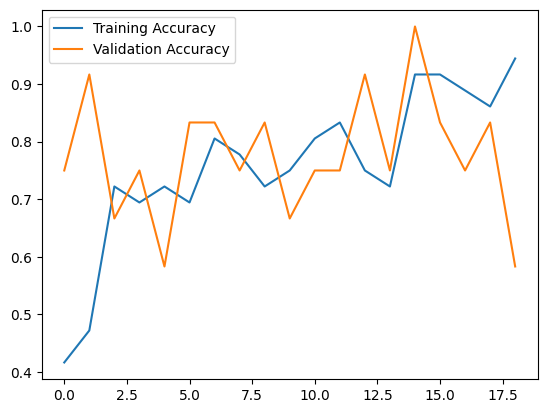

Model training completed!


In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

print("Model training completed!")

# Evaluate 

In [15]:
train_score = model.evaluate(train_generator)
valid_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ",test_score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 0.8762 - loss: 0.4392
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.7500 - loss: 0.5155
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9167 - loss: 0.4027
Train Loss:  0.4467094838619232
Train Accuracy:  0.8611111044883728
--------------------
Validation Loss:  0.5155157446861267
Validation Accuracy:  0.75
--------------------
Test Loss:  0.40271735191345215
Test Accuracy:  0.9166666865348816


# Show

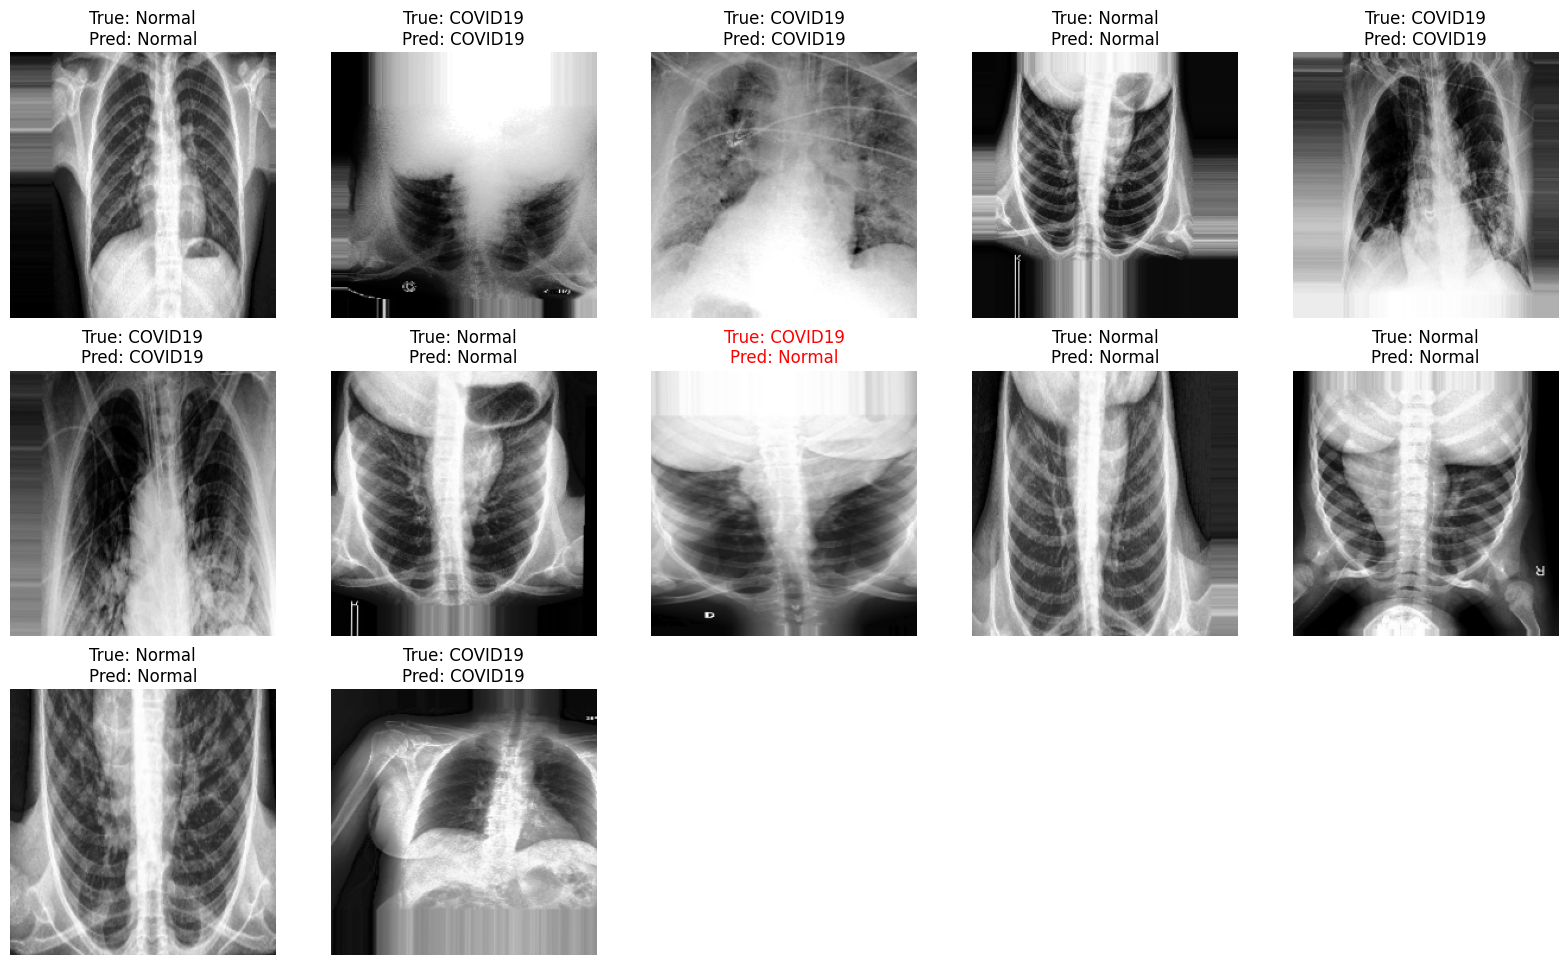

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, true_labels, predicted_labels, class_labels):
    num_images = len(images)  # Get actual number of images
    grid_size = min(25, num_images)  # Plot only available images (max 25)

    plt.figure(figsize=(20, 20))
    
    for i in range(grid_size):  
        plt.subplot(5, 5, i + 1)
        plt.imshow((images[i] * 255).astype(np.uint8))  
        plt.axis('off')
        
        true_label = class_labels[true_labels[i]]
        predicted_label = class_labels[predicted_labels[i]]

        plt.title(f"True: {true_label}\nPred: {predicted_label}",
                  color="black" if true_label == predicted_label else "red") 

    plt.show()

# Call the function
plot_images(images, true_classes, predicted_classes[:len(images)], class_labels)
